#Install Dependencies & Mount Google Drive

In [1]:
# Necessary Libraries
!pip install pandas tensorflow transformers scikit-learn numpy matplotlib seaborn imbalanced-learn openpyxl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries
- Set Random Seed for Reproducibility
- Define Custom Dataset Class

In [3]:
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Class
class ERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float),
        }

#Load Journal Dataset with 5 Emotion Regulation (ER) Categories, plus 'None' label (excluding Adaptive/Maladaptive) - 6 Labels
- Process Labels (Multi-Label Binarization)
- Train-Test Split
- Load Tokenizer & Create DataLoaders

In [5]:
# Load Dataset
file_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Assign "None" label to missing 'final_label' values
df['final_label'] = df['final_label'].fillna("None")

# Clean the labels by stripping spaces and correcting typos
df['final_label'] = df['final_label'].apply(lambda x: [label.strip() for label in x.split(", ")])  # Remove spaces and split labels

# Ensure "None" is assigned to empty labels
df['final_label'] = df['final_label'].apply(lambda x: x if x else ['None'])

# Convert labels to MultiLabel Format using the cleaned 'final_label'
mlb = MultiLabelBinarizer()
df['er_labels'] = df['final_label']  # Use cleaned labels
er_labels = mlb.fit_transform(df['er_labels'])
all_labels = list(mlb.classes_)  # This now includes "None"

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_ner'], er_labels, test_size=0.3, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset and DataLoader
max_length = 128
batch_size = 16

train_dataset = ERDataset(X_train.tolist(), y_train, tokenizer, max_length)
test_dataset = ERDataset(X_test.tolist(), y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
print(all_labels)

['Attentional Deployment', 'Cognitive Change', 'None', 'Response Modulation', 'Situation Modification', 'Situation Selection']


#Load BERT Model for Multi-Label Classification
- Define Loss Function with Class Weights
- Define Optimizer & Scheduler

In [8]:
#Load BERT Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=er_labels.shape[1],
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True  # Fix mismatch between label sizes
)
model = model.to(device)

# Loss Function with Class Weights
class_counts = np.sum(y_train, axis=0)
pos_weights = torch.tensor((len(y_train) - class_counts) / class_counts, dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and Scheduler
from torch.optim import AdamW
epochs = 10
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Save paths of Best model and Best tokenizer

In [10]:
# Save Paths For Future Use like for Prediction
model_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_6classes.pth"
tokenizer_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_tokenizer_6classes"


#Define Training Function
- Define Evaluation Function
- Training Loop & Save Best Model

In [11]:
# Training Function
def train_model(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation Function
def evaluate_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return (np.array(predictions) > threshold).astype(int), np.array(true_labels)

# Training Loop
best_f1 = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_model(model, train_loader, optimizer, loss_fn, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")
    predictions, true_labels = evaluate_model(model, test_loader, device)
    f1 = f1_score(true_labels, predictions, average="macro")
    print(f"Validation F1 Score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), model_save_path)
        tokenizer.save_pretrained(tokenizer_save_path)
        print(f"Model and tokenizer saved at {model_save_path}")

Epoch 1/10


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Train Loss: 1.0972
Validation F1 Score: 0.3422
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_6classes.pth
Epoch 2/10


100%|██████████| 22/22 [00:07<00:00,  2.91it/s]


Train Loss: 0.9691
Validation F1 Score: 0.4331
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_6classes.pth
Epoch 3/10


100%|██████████| 22/22 [00:07<00:00,  2.90it/s]


Train Loss: 0.8478
Validation F1 Score: 0.3900
Epoch 4/10


100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Train Loss: 0.7133
Validation F1 Score: 0.4462
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_6classes.pth
Epoch 5/10


100%|██████████| 22/22 [00:07<00:00,  2.81it/s]


Train Loss: 0.5647
Validation F1 Score: 0.4655
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_6classes.pth
Epoch 6/10


100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Train Loss: 0.4499
Validation F1 Score: 0.4283
Epoch 7/10


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Train Loss: 0.3513
Validation F1 Score: 0.4397
Epoch 8/10


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Train Loss: 0.2875
Validation F1 Score: 0.4433
Epoch 9/10


100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Train Loss: 0.2452
Validation F1 Score: 0.4439
Epoch 10/10


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Train Loss: 0.2227
Validation F1 Score: 0.4290


#Load Best Model & Final Evaluation

In [13]:
# Load Model for Final Evaluation on Test Set
model.load_state_dict(torch.load(model_save_path, map_location=device))
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
model.to(device)
model.eval()
predictions, true_labels = evaluate_model(model, test_loader, device)
print("Final Evaluation on Test Set")
print(classification_report(true_labels, predictions, target_names=all_labels, zero_division=1))

Final Evaluation on Test Set
                        precision    recall  f1-score   support

Attentional Deployment       0.43      0.38      0.40        53
      Cognitive Change       0.44      0.75      0.56        53
                  None       0.82      0.70      0.76        20
   Response Modulation       0.23      0.81      0.36        26
Situation Modification       0.40      0.36      0.38        11
   Situation Selection       0.25      0.50      0.33        12

             micro avg       0.38      0.60      0.46       175
             macro avg       0.43      0.58      0.47       175
          weighted avg       0.44      0.60      0.48       175
           samples avg       0.43      0.60      0.47       175



#Classification Report Using HeatMap

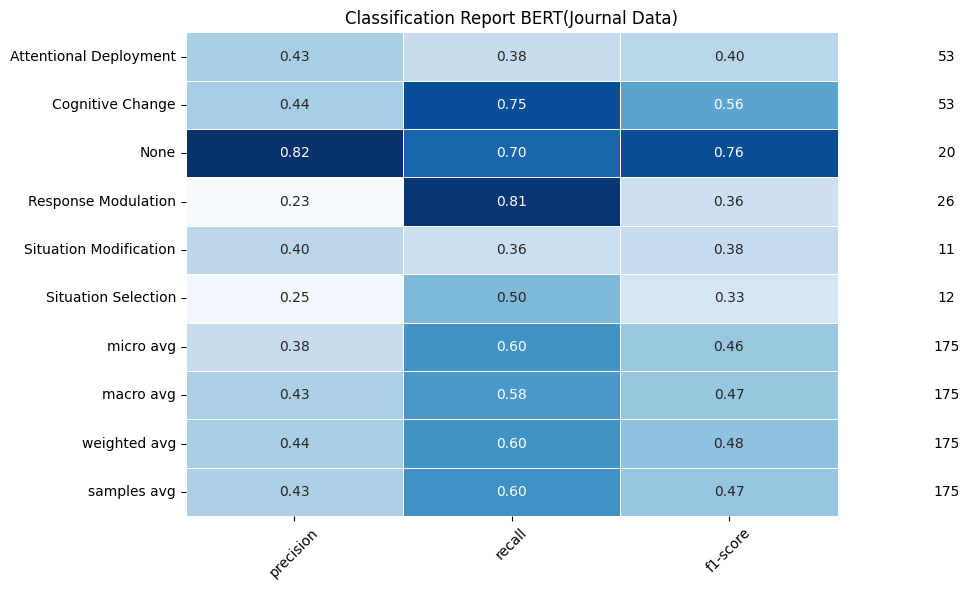

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(true_labels, predictions, target_names=all_labels, output_dict=True, zero_division=1)

# Convert to a DataFrame
df_report = pd.DataFrame(report_dict).T

# Separate the metrics and support
df_metrics = df_report.drop(columns=['support'])
df_support = df_report['support']

# Plot heatmap for metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar=False)

# Add support count as text annotations
for i, support in enumerate(df_support):
    plt.text(len(df_metrics.columns) + 0.5, i + 0.5, f"{int(support)}", ha='center', va='center')

plt.title("Classification Report BERT(Journal Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/classification_report_heatmap_bertjournal_6classes.png")
plt.show()
